# Data Loading

In [1]:
import os
import pandas as pd
from tqdm import tqdm

def read_patch_paths(image_folder, mask_folder):
    image_paths = []
    mask_paths = []

    # Get a list of image patch files in the folder
    image_files = os.listdir(image_folder)

    # Assuming the file names are the same in the mask folder
    for file_name in tqdm(image_files):
        image_path = os.path.join(image_folder, file_name)
        mask_path = os.path.join(mask_folder, file_name)

        # Check if both image and mask paths exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)

    # Create a DataFrame
    df = pd.DataFrame({'Image': image_paths, 'Mask': mask_paths})
    return df

# Specify the paths to the image and mask patch folders
image_patch_folder = "/kaggle/input/training-patches-he-512-idrid/HE_patches - Copy/image_patches_512/"
mask_patch_folder = "/kaggle/input/training-patches-he-512-idrid/HE_patches - Copy/mask_patches_512/"

# Read patch paths and create a DataFrame
df_patches = read_patch_paths(image_patch_folder, mask_patch_folder)

100%|██████████| 1168/1168 [00:03<00:00, 326.69it/s]


In [2]:
df_patches.head()

,Image,Mask
0,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
1,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
2,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
3,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
4,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...


In [7]:
#for multiclass
import cv2
import numpy as np
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    clahe_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return clahe_image

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            #A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for i, row in batch_df.iterrows():

            image = cv2.imread(row['Image'], cv2.IMREAD_COLOR)
            image = apply_clahe(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/np.max(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                mask=mask>0
    

            augmented = self.transform(image=image, mask=mask)
            images.append(augmented['image'])
            masks.append(augmented['mask'])
        
                

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        return  images, masks

# Example usage of the CustomDataGenerator
train_generator = CustomDataGenerator(df_patches, batch_size=8, image_size=(256, 256), shuffle=True)


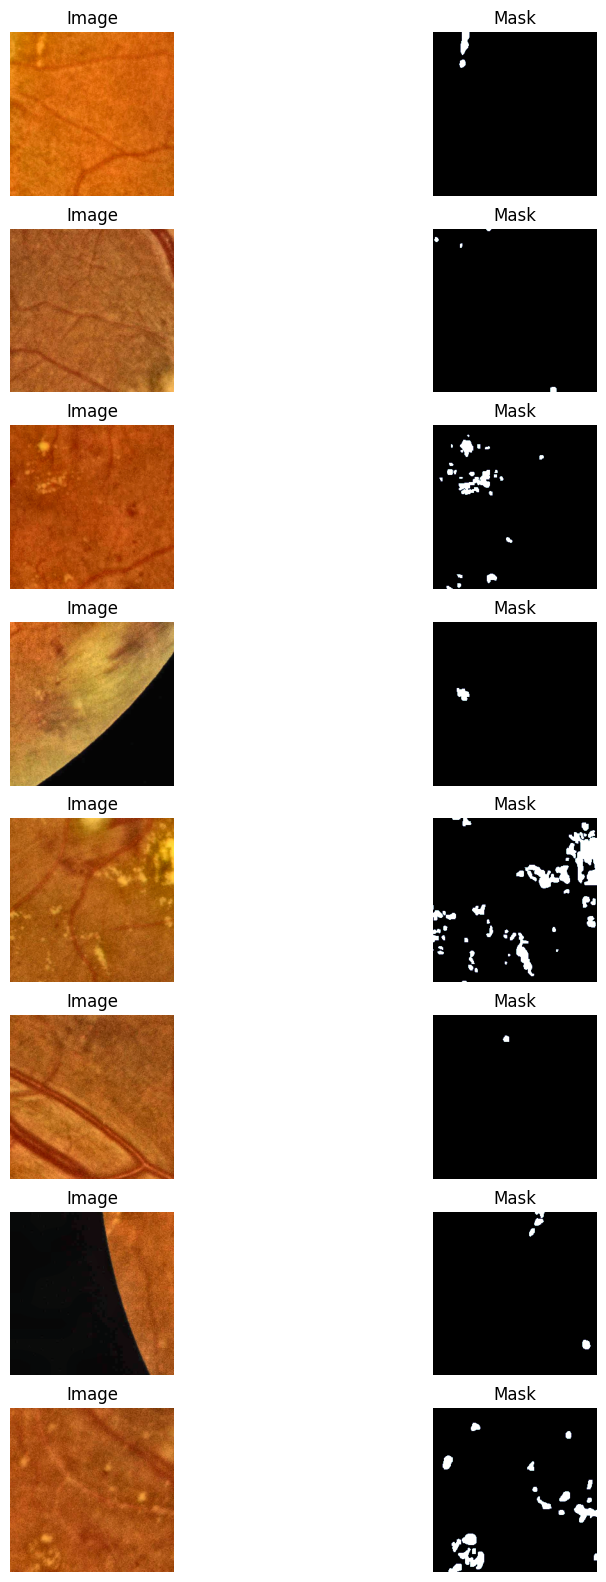

In [8]:
import matplotlib.pyplot as plt

# Load a single batch
batch = train_generator[0]  # Assuming you want to load the first batch

# Extract images and labels from the batch
images, masks = batch

# Display the images and masks
n_images_to_display = len(images)
fig, ax = plt.subplots(n_images_to_display, 2, figsize=(10, 20))
for i in range(n_images_to_display):
    ax[i, 0].imshow(images[i], cmap='bone')
    #print(np.max(images[i]))
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(masks[i], cmap='bone')
    #print(np.max(masks[i]))
    ax[i, 1].set_title('Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

df_shuffled = df_patches.sample(frac=1, random_state=42)
train_df, val_df = train_test_split(df_shuffled, test_size=0.2, random_state=42)

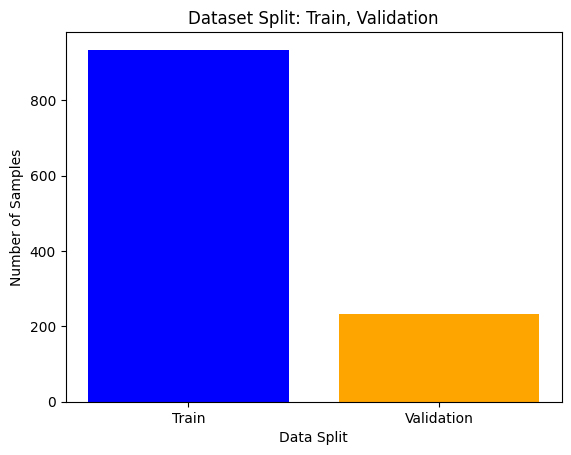

In [10]:
# bar plot
from matplotlib import pyplot as plt
sizes = [len(train_df), len(val_df)]
labels = ['Train', 'Validation']

plt.bar(labels, sizes, color=['blue', 'orange'])
plt.xlabel('Data Split')
plt.ylabel('Number of Samples')
plt.title('Dataset Split: Train, Validation')
plt.show()

# Model Architecture and Helper blocks

In [11]:
#GCSE Block...from the GCSER UNET (Mukherjee et al.)
def GCSE(input_tensor, ratio=16):


    # Compute the global statistics (mean and std deviation) along the channel axis.
    mean = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
    std = tf.math.reduce_std(input_tensor, axis=[1, 2], keepdims=True)

    # Compute channel-wise attention using a convolutional neural network.
    attn_channel = tf.concat([mean, std], axis=-1)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1] // ratio, kernel_size=(1, 1), activation='relu')(attn_channel)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), activation='sigmoid')(attn_channel)

    # Compute spatial attention using global information from the input tensor.
    global_info = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    attn_spatial = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(global_info)

    # Combine channel-wise and spatial attention.
    attn = tf.keras.layers.Multiply()([attn_channel,attn_spatial])

    # Multiply the input tensor by the learned attention weights.
    output_tensor = tf.keras.layers.Multiply()([input_tensor,attn])

    return output_tensor

In [12]:
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=3, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=5, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=7, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [13]:
from tensorflow.keras.applications import ResNet50
def build_encoder2(inputs):

    s=[]
    """ Pre-trained ResNet50 Model """
    resnet50= ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in resnet50.layers:
        layer.trainable = True


    """ Encoder """
    s1 = resnet50.get_layer("model_input").output    
    s.append(s1)
    s2 = resnet50.get_layer("conv1_relu").output   
    s.append(s2)
    s3 = resnet50.get_layer("conv2_block3_out").output  
    s.append(s3)
    s4 = resnet50.get_layer("conv3_block4_out").output  
    s.append(s4)

    """ Bridge """
    #b1 = resnet50.get_layer("conv4_block6_out").output 
    b = resnet50.get_layer("conv4_block2_out").output 
    b = ASPP(b,128)
    
    encoder2 = Model(inputs,outputs=[s,b],name = "encoder2")

    return encoder2

In [14]:
# Code for W-Net

from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.models import Model


def complementary_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.math.sigmoid(mse_loss)


def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    #x = Activation("relu")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    return x

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)


    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, s1,s2, num_filters):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x,s1,s2])
    x = residual_block(x, num_filters)
    x = GCSE(x)
    return x
def build_encoder1(inputs,f):
    
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(f[0], 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)

    c1 = x + s
    c1 = GCSE(c1)
    p1 = MaxPooling2D((2,2))(c1)
    s1 = c1

    c2 = residual_block(p1, f[1])
    c2 = GCSE(c2)
    p2 = MaxPooling2D((2,2))(c2)
    s2 = c2

    c3 = residual_block(p2, f[2])
    c3 = GCSE(c3)
    p3 = MaxPooling2D((2,2))(c3)
    s3 = c3

    c4 = residual_block(p3, f[3])
    c4 = GCSE(c4)
    p4 = MaxPooling2D((2,2))(c4)
    s4 = c4
    
    s_ = [s1,s2,s3,s4]
    """ Bridge """
    b = ASPP(p4,128)
    encoder1 = Model(inputs,outputs=[s_,b],name="encoder1")
    return encoder1

    
    

def build_WNet(input_shape):
    f = [64,128,256,512]

    inputs = Input(input_shape,name="model_input")
    encoder1 = build_encoder1(inputs,f)
    encoder2 = build_encoder2(inputs)
    s1,b1 = encoder1(inputs)
    s2,b2 = encoder2(inputs)

    b = Concatenate()([b1,b2])

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s2[3],s1[3], f[3])
    d2 = decoder_block(d1, s2[2],s1[2], f[2])
    d3 = decoder_block(d2, s2[1],s1[1], f[1])
    d4 = decoder_block(d3, s2[0],s1[0],f[0])
    
    #comp1 = complementary_loss(s2[0], s1[0])
    #comp2 = complementary_loss(s2[1], s1[1])
    comp3 = complementary_loss(s2[2], s1[2])
    comp4 = complementary_loss(s2[3], s1[3])
    comp5 = complementary_loss(b1, b2)
    

    output_2 = tf.keras.layers.Add(name='output_2')([comp3,comp4,comp5])

    """ Classifier """
    output_1 = Conv2D(1, (1,1) , activation="sigmoid",name='output_1')(d4)

    """ Model """
    model = Model(inputs,outputs=[output_1,output_2])
    return model

# Evaluation Metrics

In [65]:
from keras import backend as K
import tensorflow as tf
epsilon = 1e-5
smooth = 1e-5

def dice_coeff(y_true, y_pred, smooth=1):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice

def dice_loss(y_true, y_pred, smooth=1):
    return  1- dice_coeff(y_true, y_pred, smooth=1)

def FocalLoss(targets, inputs, alpha=0.75, gamma=2):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred, smooth=1) + FocalLoss(y_true, y_pred, 0.25,2)
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def iou_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou


In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import CSVLogger
model = build_WNet((256,256,3))
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)

94765736/94765736 [==============================] - 3s 0us/step


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 model_input (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 encoder1 (Functional)       [[(None, 256, 256, 64),      6916164   ['model_input[0][0]']         
                              (None, 128, 128, 128),                                              
                              (None, 64, 64, 256),                                                
                              (None, 32, 32, 512)],                                               
                              (None, 16, 16, 128)]                                                
                                                                                              

In [18]:
model.compile(optimizer=adam, loss={'output_1':total_loss, 'output_2':lambda y_true, y_pred: y_pred},
              loss_weights = {'output_1':1, 'output_2':-0.02},
              metrics = {"output_1":[iou_score,dice_coeff,tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),sensitivity,specificity,tf.keras.metrics.AUC()]})

#callbacks
csv_logger = CSVLogger('/kaggle/working/training_log_WCE_segmentation', separator=',', append=True)
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=9
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/kaggle/working/WNet_maxpool.h5", 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6, verbose=1)
                              
"""reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=4,
                              min_delta=0.000001,
                              factor=0.3
                             )"""
callbacks = [checkpointer, earlystopping, reduce_lr, csv_logger]

# Iterative Training Scheme
# Two losses are used: 
* for segmentation: $Dice Loss + Focal Loss$
* $Complementary~Loss$: to ensure that both models do not learn the same features

In [20]:
batch_size = 4
N = 256
train_generator = CustomDataGenerator(train_df, batch_size=batch_size, image_size=(N,N), shuffle=True)
val_generator = CustomDataGenerator(val_df, batch_size=batch_size, image_size=(N,N), shuffle=False)
num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Set the training status for encoder1 and encoder2
    if epoch % 2 == 0:
        model.get_layer('encoder1').trainable = True
        model.get_layer('encoder2').trainable = False
    else:
        model.get_layer('encoder1').trainable = False
        model.get_layer('encoder2').trainable = True

    # Train the model for one epoch
    history = model.fit(train_generator, steps_per_epoch=len(train_df) // batch_size,
                    validation_data=val_generator, validation_steps=len(val_df) // batch_size,
                    epochs=1,callbacks=callbacks)

# Save the final trained model
model.save('final_model.h5')

Epoch 1/50


2023-12-31 16:04:49.745574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/encoder1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


233/233 [==============================] - ETA: 0s - loss: 0.4586 - output_1_loss: 0.5109 - output_2_loss: 2.6164 - output_1_iou_score: 0.2906 - output_1_dice_coeff: 0.5133 - output_1_precision: 0.5299 - output_1_recall: 0.5634 - output_1_sensitivity: 0.6045 - output_1_specificity: 0.9852 - output_1_auc: 0.8579
Epoch 1: val_loss improved from inf to 1.00245, saving model to /kaggle/working/WNet_maxpool.h5
233/233 [==============================] - 139s 317ms/step - loss: 0.4586 - output_1_loss: 0.5109 - output_2_loss: 2.6164 - output_1_iou_score: 0.2906 - output_1_dice_coeff: 0.5133 - output_1_precision: 0.5299 - output_1_recall: 0.5634 - output_1_sensitivity: 0.6045 - output_1_specificity: 0.9852 - output_1_auc: 0.8579 - val_loss: 1.0024 - val_output_1_loss: 1.0620 - val_output_2_loss: 2.9771 - val_output_1_iou_score: 1.3973e-04 - val_output_1_dice_coeff: 7.1452e-04 - val_output_1_precision: 0.0000e+00 - val_output_1_recall: 0.0000e+00 - val_output_1_sensitivity: 0.0000e+00 - val_outp

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
history.history.keys()

dict_keys(['loss', 'output_1_loss', 'output_2_loss', 'output_1_iou_score', 'output_1_dice_coeff', 'output_1_precision', 'output_1_recall', 'output_1_sensitivity', 'output_1_specificity', 'output_1_auc', 'val_loss', 'val_output_1_loss', 'val_output_2_loss', 'val_output_1_iou_score', 'val_output_1_dice_coeff', 'val_output_1_precision', 'val_output_1_recall', 'val_output_1_sensitivity', 'val_output_1_specificity', 'val_output_1_auc', 'lr'])

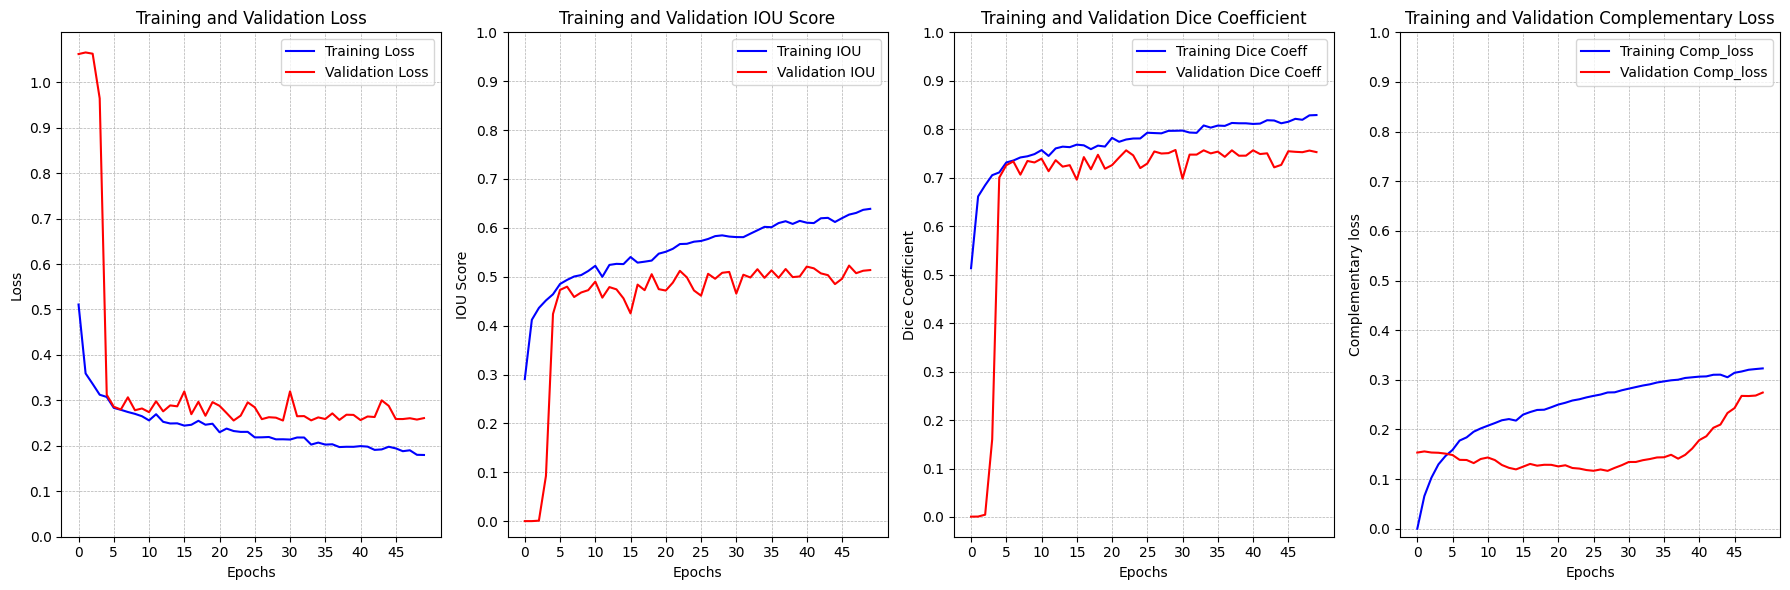

In [46]:
from matplotlib import pyplot as plt
history = pd.read_csv('/kaggle/working/training_log_WCE_segmentation', sep=',', engine='python')

#history= history

############### ########## ####### #######

iou_score=history['output_1_iou_score']
val_iou_score=history['val_output_1_iou_score']

loss=history['output_1_loss']
val_loss=history['val_output_1_loss']

train_dice=history['output_1_dice_coeff']
val_dice=history['val_output_1_dice_coeff']

train_cl = history['output_2_loss']
train_cl = train_cl-np.min(train_cl)
val_cl = history['val_output_2_loss']
val_cl = val_cl-np.min(val_cl)


epoch = np.arange(len(loss))

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

# Plot 1: Loss
axes[0].plot(epoch, loss, 'b', label='Training Loss', linewidth=1.5)
axes[0].plot(epoch, val_loss, 'r', label='Validation Loss', linewidth=1.5)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot 2: IOU Scores
axes[1].plot(epoch, iou_score, 'b', label='Training IOU', linewidth=1.5)
axes[1].plot(epoch, val_iou_score, 'r', label='Validation IOU', linewidth=1.5)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU Score')
axes[1].set_title('Training and Validation IOU Score')
axes[1].legend()

# Plot 3: Dice Coefficients
axes[2].plot(epoch, train_dice, 'b', label='Training Dice Coeff', linewidth=1.5)
axes[2].plot(epoch, val_dice, 'r', label='Validation Dice Coeff', linewidth=1.5)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Dice Coefficient')
axes[2].set_title('Training and Validation Dice Coefficient')
axes[2].legend()

# Plot 3: Dice Coefficients
axes[3].plot(epoch, train_cl, 'b', label='Training Comp_loss', linewidth=1.5)
axes[3].plot(epoch, val_cl, 'r', label='Validation Comp_loss', linewidth=1.5)
axes[3].set_xlabel('Epochs')
axes[3].set_ylabel('Complementary loss')
axes[3].set_title('Training and Validation Complementary Loss')
axes[3].legend()

# Customize tick marks and labels
for ax in axes:
    ax.grid(True)
    ax.set_xticks(np.arange(0, len(epoch), 5))  # Adjust the x-axis ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))  # Adjust the y-axis ticks
    ax.grid(which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()

# Fine-tuning Joint updation

In [69]:
from tensorflow.keras.models import load_model

custom_objects = {'total_loss': total_loss,
                  '<lambda>': lambda y_true, y_pred: y_pred,
                  'iou_score':iou_score,
                  'dice_coeff':dice_coeff,
                  'precision':tf.keras.metrics.Precision(),
                  'recall':tf.keras.metrics.Recall(),
                  'sensitivity':sensitivity,
                  'specificity':specificity
                 }

with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model('/kaggle/working/final_model.h5')

In [71]:

csv_logger = CSVLogger('/kaggle/working/training_log_WCE_segmentation', separator=',', append=True)
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=3
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/kaggle/working/WNet_maxpool_fine_tune.h5", 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6, verbose=1)
                              
"""reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=4,
                              min_delta=0.000001,
                              factor=0.3
                             )"""
callbacks = [checkpointer, earlystopping, reduce_lr, csv_logger]

In [72]:
batch_size = 4
N = 256
train_generator = CustomDataGenerator(train_df, batch_size=batch_size, image_size=(N,N), shuffle=True)
val_generator = CustomDataGenerator(val_df, batch_size=batch_size, image_size=(N,N), shuffle=False)
history = model.fit(train_generator, steps_per_epoch=len(train_df) // batch_size,
                    validation_data=val_generator, validation_steps=len(val_df) // batch_size,
                    epochs=10,callbacks=callbacks)

Epoch 1/10


2023-12-31 19:31:06.945684: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/encoder1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


233/233 [==============================] - ETA: 0s - loss: 0.2104 - output_1_loss: 0.2667 - output_2_loss: 2.8143 - output_1_iou_score: 0.5123 - output_1_dice_coeff: 0.7484 - output_1_precision: 0.8184 - output_1_recall: 0.7670 - output_1_sensitivity: 0.7599 - output_1_specificity: 0.9949 - output_1_auc: 0.9312
Epoch 1: val_loss improved from inf to 0.23444, saving model to /kaggle/working/WNet_maxpool_fine_tune.h5
233/233 [==============================] - 92s 243ms/step - loss: 0.2104 - output_1_loss: 0.2667 - output_2_loss: 2.8143 - output_1_iou_score: 0.5123 - output_1_dice_coeff: 0.7484 - output_1_precision: 0.8184 - output_1_recall: 0.7670 - output_1_sensitivity: 0.7599 - output_1_specificity: 0.9949 - output_1_auc: 0.9312 - val_loss: 0.2344 - val_output_1_loss: 0.2923 - val_output_2_loss: 2.8942 - val_output_1_iou_score: 0.4505 - val_output_1_dice_coeff: 0.7222 - val_output_1_precision: 0.8084 - val_output_1_recall: 0.8084 - val_output_1_sensitivity: 0.7218 - val_output_1_specif

In [73]:
# Save the final trained model
model.save('final_model_fine_tuned.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


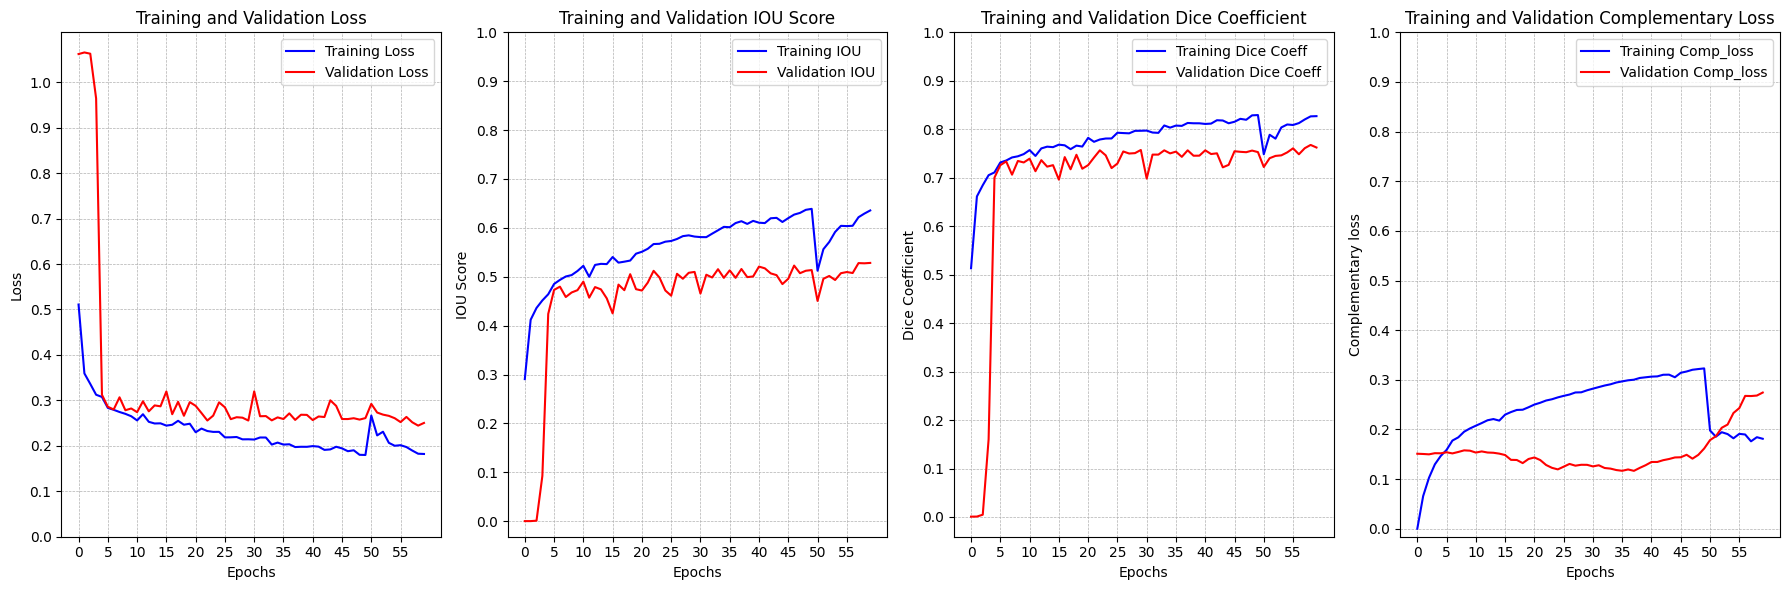

In [78]:
from matplotlib import pyplot as plt
history = pd.read_csv('/kaggle/working/training_log_WCE_segmentation', sep=',', engine='python')

#history= history

############### ########## ####### #######

iou_score=history['output_1_iou_score']
val_iou_score=history['val_output_1_iou_score']

loss=history['output_1_loss']
val_loss=history['val_output_1_loss']

train_dice=history['output_1_dice_coeff']
val_dice=history['val_output_1_dice_coeff']

train_cl = history['output_2_loss']
train_cl = train_cl-np.min(train_cl)
val_cl = history['val_output_2_loss']
val_cl = val_cl-np.min(val_cl)


epoch = np.arange(len(loss))

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

# Plot 1: Loss
axes[0].plot(epoch, loss, 'b', label='Training Loss', linewidth=1.5)
axes[0].plot(epoch, val_loss, 'r', label='Validation Loss', linewidth=1.5)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot 2: IOU Scores
axes[1].plot(epoch, iou_score, 'b', label='Training IOU', linewidth=1.5)
axes[1].plot(epoch, val_iou_score, 'r', label='Validation IOU', linewidth=1.5)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU Score')
axes[1].set_title('Training and Validation IOU Score')
axes[1].legend()

# Plot 3: Dice Coefficients
axes[2].plot(epoch, train_dice, 'b', label='Training Dice Coeff', linewidth=1.5)
axes[2].plot(epoch, val_dice, 'r', label='Validation Dice Coeff', linewidth=1.5)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Dice Coefficient')
axes[2].set_title('Training and Validation Dice Coefficient')
axes[2].legend()

# Plot 3: Dice Coefficients
axes[3].plot(epoch, train_cl, 'b', label='Training Comp_loss', linewidth=1.5)
axes[3].plot(epoch, val_cl, 'r', label='Validation Comp_loss', linewidth=1.5)
axes[3].set_xlabel('Epochs')
axes[3].set_ylabel('Complementary loss')
axes[3].set_title('Training and Validation Complementary Loss')
axes[3].legend()

# Customize tick marks and labels
for ax in axes:
    ax.grid(True)
    ax.set_xticks(np.arange(0, len(epoch), 5))  # Adjust the x-axis ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))  # Adjust the y-axis ticks
    ax.grid(which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()

In [79]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/training_log_WCE_segmentation (deflated 53%)
  adding: kaggle/working/WNet_maxpool_fine_tune.h5 (deflated 8%)
  adding: kaggle/working/WNet_maxpool.h5 (deflated 8%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/final_model.h5 (deflated 8%)
  adding: kaggle/working/final_model_fine_tuned.h5 (deflated 8%)


In [80]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip